### **Predictive power of moving averages was weak (R²≈0)**

### Therefore, we will be testing alternative models

In [1]:
import pandas as pd

# Load dataset
data= pd.read_csv("entertainment_stocks.csv")

print(data['Company'].unique())

['Cogeco Communications' 'Cineplex' 'Corus Entertainment (CJR.B)'
 'Quebecor' 'Stingray Group' 'Rogers Communications' 'Spin Master'
 'WildBrain']


##### For ARIMA and GARCH, we will focus on one firm 

##### **Quebecor for defensive and Cineplex for speculative**

In [3]:
# Quebecor returns
qc_returns = data[data['Company'] == "Quebecor"]['Daily_Return'].dropna()

# Cineplex returns
cineplex_returns = data[data['Company'] == "Cineplex"]['Daily_Return'].dropna()

### **ARIMA**

/var/folders/br/ng89_vjs55b9fqgsky6n1_9m0000gn/T/ipykernel_19175/1355933955.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  qc['Date'] = pd.to_datetime(qc['Date'])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for fo

                               SARIMAX Results                                
Dep. Variable:           Daily_Return   No. Observations:                 1254
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3669.092
Date:                Sun, 07 Sep 2025   AIC                          -7332.184
Time:                        21:28:45   BIC                          -7316.784
Sample:                             0   HQIC                         -7326.395
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0749      0.022      3.347      0.001       0.031       0.119
ma.L1         -1.0000      0.372     -2.687      0.007      -1.729      -0.271
sigma2         0.0002   6.23e-05      2.674      0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


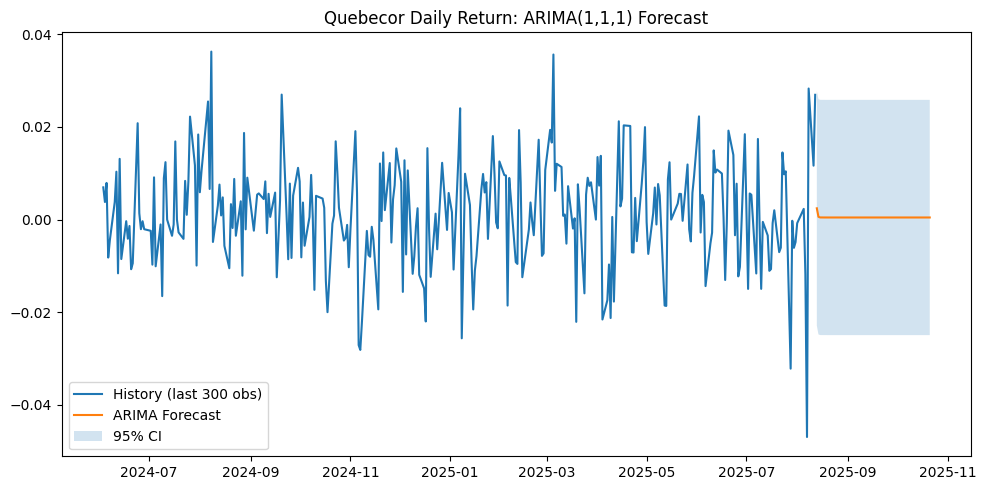

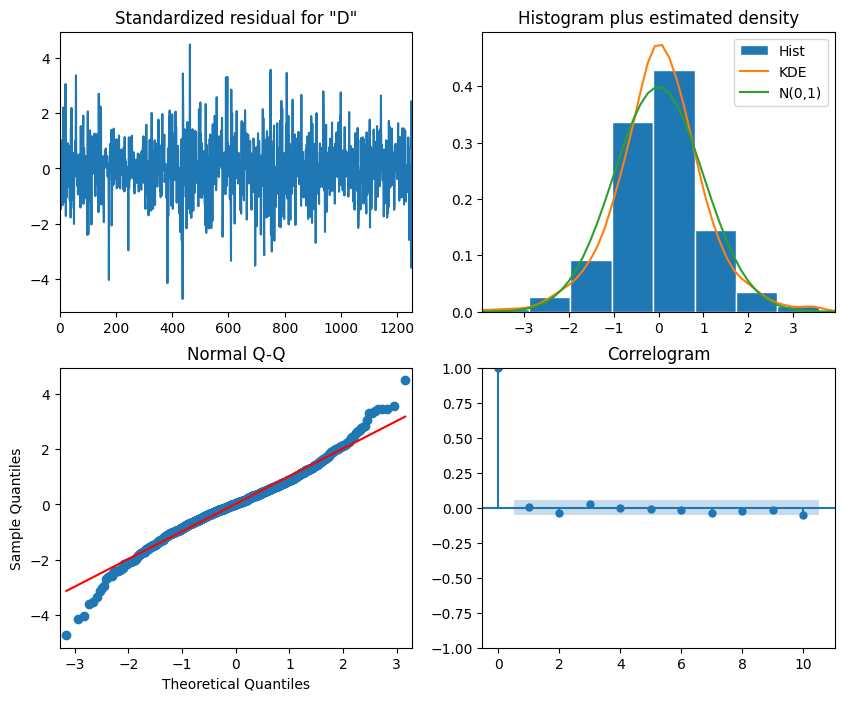

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Quebecor daily returns (ensure datetime index for nice plots)
qc = data[data['Company'] == "Quebecor"].copy()
qc['Date'] = pd.to_datetime(qc['Date'])
qc = qc.set_index('Date').sort_index()

y = qc['Daily_Return'].dropna()

# Try ARIMA(1,0,1) for returns (often stationary). If it fails, switch to (1,1,1).
model = ARIMA(y, order=(1,1,1))
res = model.fit()
print(res.summary())

# Forecast next N steps
N = 50
fcst = res.get_forecast(steps=N)
mean_fcst = fcst.predicted_mean
conf_int = fcst.conf_int(alpha=0.05)

# Build a combined series for plotting: history + forecast
hist_end = y.index[-1]
forecast_index = pd.date_range(start=hist_end + pd.Timedelta(days=1), periods=N, freq='B')  # business days
mean_fcst.index = forecast_index
conf_int.index = forecast_index

plt.figure(figsize=(10,5))
plt.plot(y.index[-300:], y[-300:], label="History (last 300 obs)")
plt.plot(mean_fcst.index, mean_fcst, label="ARIMA Forecast")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label="95% CI")
plt.title("Quebecor Daily Return: ARIMA(1,1,1) Forecast")
plt.legend()
plt.tight_layout()
plt.show()

# Optional diagnostics
res.plot_diagnostics(figsize=(10,8))
plt.show()


### **GARCH**

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2803.68
Distribution:                  Normal   AIC:                          -5599.35
Method:            Maximum Likelihood   BIC:                          -5578.82
                                        No. Observations:                 1254
Date:                Sun, Sep 07 2025   Df Residuals:                     1253
Time:                        21:30:50   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.2884e-04  7.113e-04      0.884      0.377 

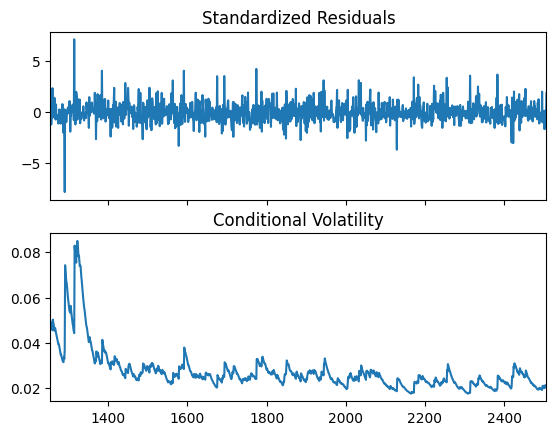

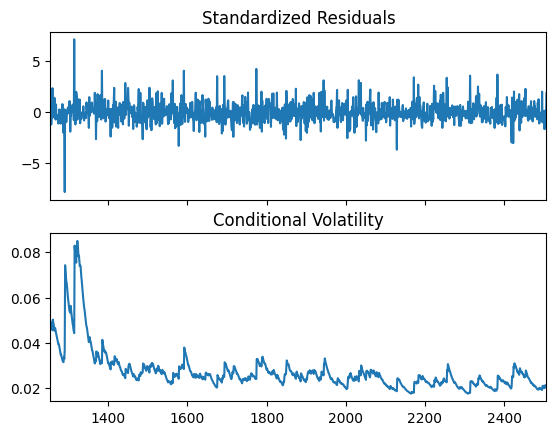

In [11]:
from arch import arch_model

cine = data[data['Company'] == "Cineplex"].copy()
cine_returns = cine['Daily_Return'].dropna()

garch = arch_model(cine_returns, vol='Garch', p=1, q=1)
garch_fit = garch.fit(disp="off")
print(garch_fit.summary())
garch_fit.plot()